# pythia-level-threshold-mutli

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from utils import utils, stats
from importlib import reload
from itertools import product
reload(stats)

<module 'utils.stats' from '/u/cmolder/GitHub/394r-project-analysis/utils/stats.py'>

In [4]:
data_paths = {
    'Plain': '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r.csv',
    #'γ=0': '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_gamma_0.csv',
    #'Separate EQ': '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_separate_eq.csv',
    #'Separate EQ Long': '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_separate_eq_long.csv',
}

# Check gamma
# data_paths = {
#     'γ~0.55': '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r.csv',
#     'γ=0': '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_gamma_0.csv',
# }

# # Check improvements
# data_paths = {
#     'Plain': '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r.csv',
#     'Separate EQ': '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_separate_eq.csv',
#     'Separate EQ Long': '/u/cmolder/GitHub/Pythia/out/pythia_level/exp_394r/exp_394r_separate_eq_long.csv',
# }
data_df = {}
for setup in data_paths.keys():
    data_df[setup] = utils.read_data_file(data_paths[setup])

In [5]:
data_df['Plain'].full_trace.unique()

array(['astar_163B', 'bwaves_1861B', 'bzip2_183B', 'cactusADM_734B',
       'calculix_2655B', 'gcc_13B', 'bc', 'GemsFDTD_109B', 'lbm_94B',
       'leslie3d_1116B', 'libquantum_1210B', 'mcf_46B', 'milc_360B',
       'omnetpp_340B', 'soplex_66B', 'sphinx3_2520B', 'tonto_422B',
       'wrf_1212B', 'xalancbmk_748B', 'zeusmp_600B', 'bfs', 'cc', 'tc',
       'pr', 'sssp'], dtype=object)

---
## Metrics of each static threshold
- How does each static threshold compare to regular Pythia, and no prefetcher?

In [6]:
def plot_metric(dfs, metric, dpi=192, suite_name=None):
    fig, ax = plt.subplots(dpi=dpi)#, figsize=(16, 5))
    num_samples = len(dfs.items())
    gap = 2 * num_samples + 1

    for i, (setup, df) in enumerate(dfs.items()):
        df = df[df.pythia_level_threshold == float('-inf')]
        df = stats.add_means(df) # Add mean as an extra trace
    
        for j, tr in enumerate(df.trace.unique()):
            rows = df[df.trace == tr]
            pos = gap*j + 2*i
            #print(f'[DEBUG] i={i} j={j} setup={setup} tr={tr} pos={pos}, {pos+1}')
            
            p_samples = rows[rows.all_pref.apply(lambda x : x == ('no', 'pythia', 'no'))][metric]
            p_mean = p_samples.mean()
            p_min = p_samples.min()
            p_max = p_samples.max()
            
            #print(f'[DEBUG] {tr} Regular {setup} {p_mean:.2f} {p_min:.2f} {p_max:.2f}')
            ax.bar(
                pos, p_mean, label=f'Regular ({setup})' if j == 0 else None, color='C0'
            )
            ax.errorbar(
                pos, p_mean, yerr= [[p_mean - p_min], [p_max - p_mean]], color='black'
            )
            
            dp_samples = rows[rows.all_pref.apply(lambda x : x == ('no', 'double_pythia', 'no'))][metric]
            dp_mean = dp_samples.mean()
            dp_min = dp_samples.min()
            dp_max = dp_samples.max()
            
            #print(f'[DEBUG] {tr} Double {setup} {dp_mean:.2f} {dp_min:.2f} {dp_max:.2f}')
            ax.bar(
                pos + 1, dp_mean, label=f'Double ({setup})' if j == 0 else None, color='C1'
            )
            ax.errorbar(
                pos + 1, dp_mean, yerr=[[dp_mean - dp_min], [dp_max - dp_mean]], color='black'
            )

    ax.set_xticks(
        np.arange(0, len(df.trace.unique())) * gap + (num_samples/2)
    )
    
    
    if metric in utils.amean_metrics:
        traces = df.trace.replace('mean', 'amean').unique()
    else:
        traces = df.trace.replace('mean', 'gmean').unique()
    ax.set_xticklabels(traces, rotation=90)
        
    ax.set_xlabel('Trace')
    ax.set_ylabel(metric)
        
    #fig.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    fig.legend()
    fig.suptitle(f'{metric} ({suite_name})')  if suite_name is not None else fig.suptitle(f'{metric}')
    #fig.tight_layout()

In [7]:
os.makedirs('./plots/pythia_level_threshold_multi/ipc_improvement', exist_ok=True)
os.makedirs('./plots/pythia_level_threshold_multi/L2C_mpki_reduction', exist_ok=True)
os.makedirs('./plots/pythia_level_threshold_multi/LLC_mpki_reduction', exist_ok=True)
os.makedirs('./plots/pythia_level_threshold_multi/pythia_confidence', exist_ok=True)

---
# Regular vs. Double Pythia

In [ ]:
dpi=120

#for suite_name, suite in zip(['SPEC'], [utils.spec06]):
for suite_name, suite in zip(['SPEC \'06', 'GAP'], [utils.spec06, utils.gap]):

    data_df_ = {k : v[v.trace.isin(suite)] for k,v in data_df.items()}
    for metric in ['ipc_improvement', 'LLC_mpki_reduction', 'L2C_mpki_reduction']:
    #for metric in ['ipc_improvement']: 
        plot_metric(
            data_df_, metric, 
            suite_name=suite_name, dpi=dpi
        )
        plt.savefig(
            f'./plots/pythia_level_threshold_multi/{suite_name}_{metric}.pdf', 
            bbox_inches='tight'
        )

---
# Regular vs. Double vs. Static-Threshold Pythia

In [45]:
def plot_threshold_metric(dfs, trace, metric, dpi=192, error=None):
    
    fig, ax = plt.subplots(dpi=dpi)
    
    for setup, df in dfs.items():
        df = df[df.trace == trace]#[['pythia_level_threshold', metric]])
        df = df.sort_values('all_pref')
        df = df.sort_values('pythia_level_threshold')
        
        # Gather points for line
        prefs, pyth_lts, X, y_min, y_mean, y_max = [], [], [], [], [], []
        
        for i, (pf, pyth_lt) in enumerate(product(df.all_pref.unique(), df.pythia_level_threshold.unique())):
            if pf != ('no', 'pythia', 'no') and pyth_lt != float('-inf'):
                continue
            df_ = df[(df.all_pref == pf) & (df.pythia_level_threshold == pyth_lt)][metric]
            
            #print('[DEBUG]', pf, pyth_lt, df_.mean())
            prefs.append(pf)
            pyth_lts.append(pyth_lt)
            y_mean.append(df_.mean())
            y_min.append(df_.min())
            y_max.append(df_.max())
        
        y_mean = np.array(y_mean)
        y_min = np.array(y_min)
        y_max = np.array(y_max)
        
        # Line + shaded error region
        if error == 'shaded':
            ax.plot(
                np.arange(len(y_mean)), y_mean,
                label=setup, marker='.'
            )
            ax.fill_between(
                np.arange(len(y_mean)), y_min, y_max,
                alpha=0.33
            )
        elif error == 'bar':
            ax.errorbar(
                np.arange(len(y_mean)), y_mean, yerr=[y_mean - y_min, y_max - y_mean],
                label=setup, marker='.'
            )
        else:
            ax.plot(
                np.arange(len(y_mean)), y_mean,
                label=setup, marker='.'
            )
        
        
        if setup == 'Plain':
            plt.axhline(y=y_mean[1], linewidth=0.75, ls='--', color='red') # Plain Regular Pythia baseline
    
    ax.set_xticks(np.arange(len(y_mean)))
    ax.set_xticklabels([
        'Double' if prefs[i] == ('no', 'double_pythia', 'no') else
        'Regular' if pyth_lts[i] == float('-inf') else 
        str(pyth_lts[i]) 
        for i in range(len(prefs))
    ], rotation=45)
                          
    ax.set_xlabel('Static level threshold')
    ax.set_ylabel(metric)
    #ax.set_ylim(ymin=0)
    
    #plt.axhline(y=0, linewidth=0.75, ls='--', color='black') # No prefetcher baseline
    fig.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
    fig.suptitle(f'{trace} {metric}')
    fig.tight_layout()

## IPC improvement

In [46]:
traces = data_df[list(data_df.keys())[0]].trace

/tmp/ipykernel_28820/1027629572.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(dpi=dpi)


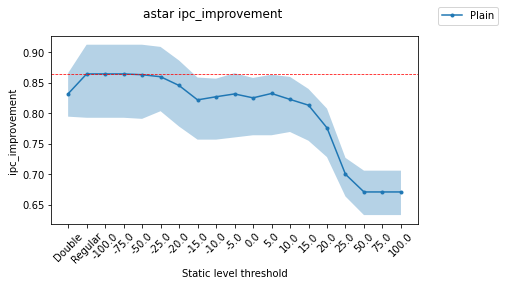

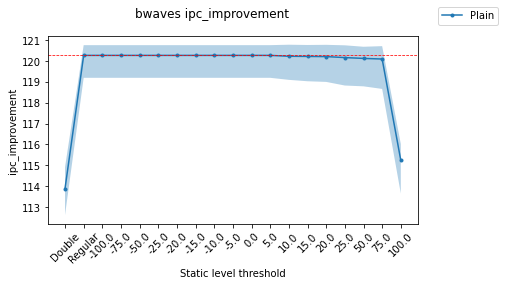

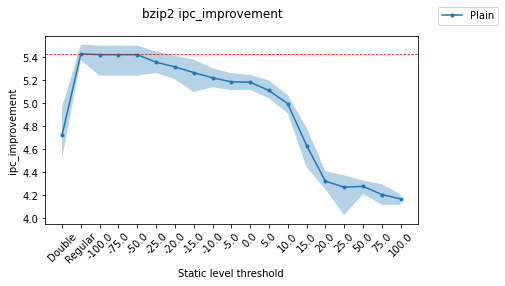

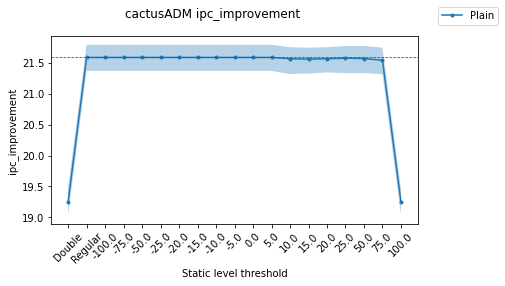

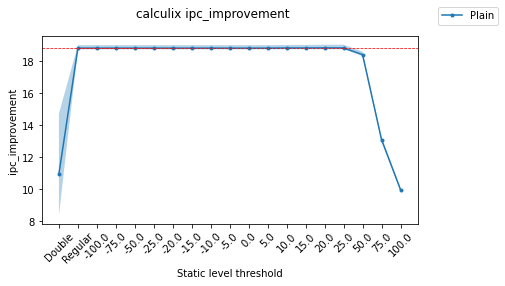

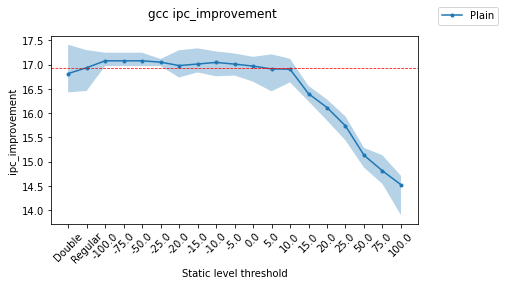

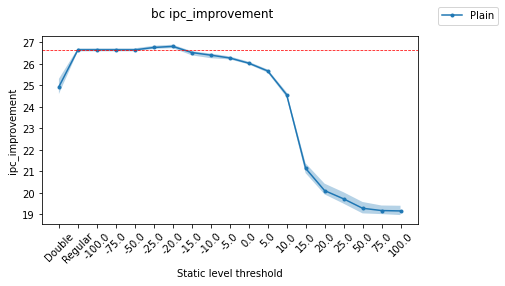

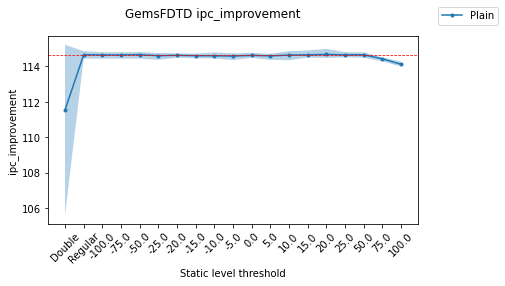

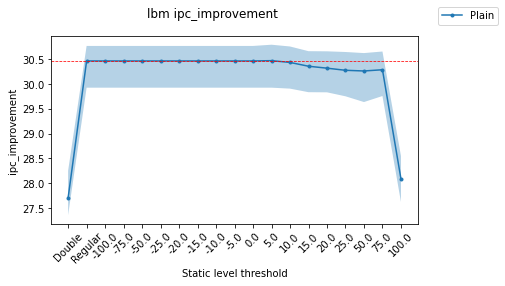

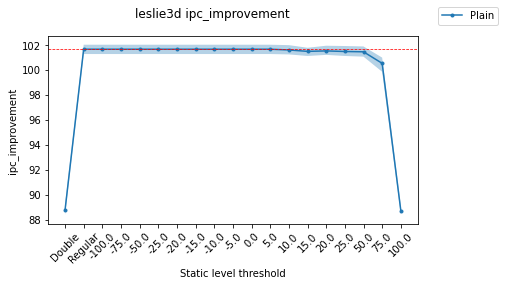

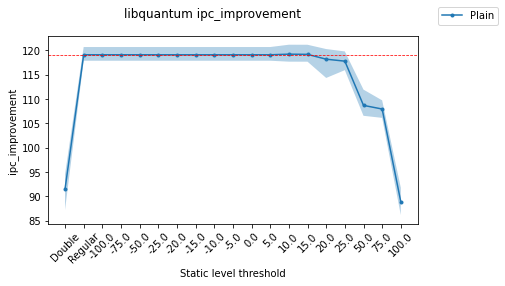

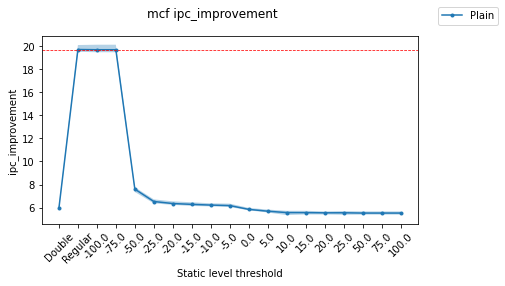

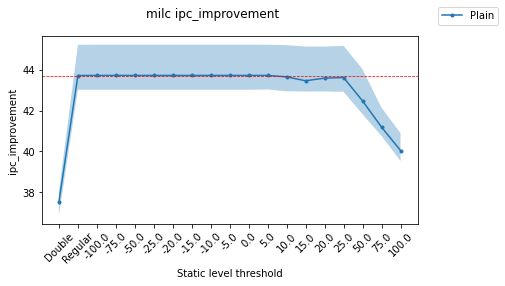

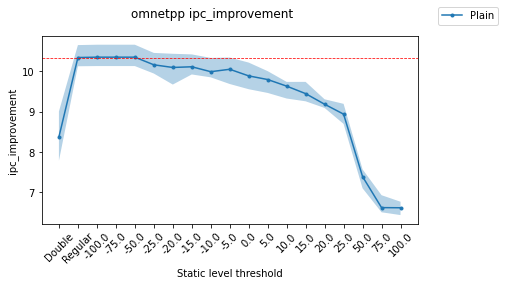

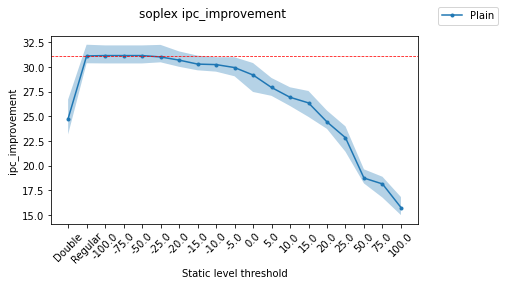

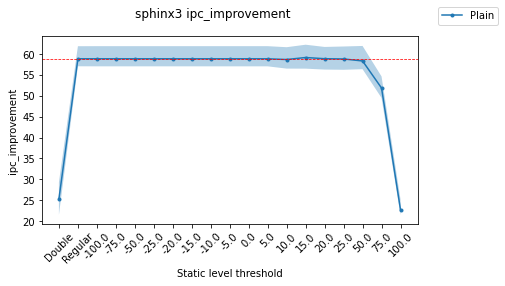

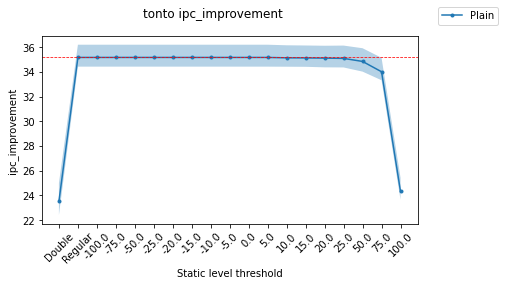

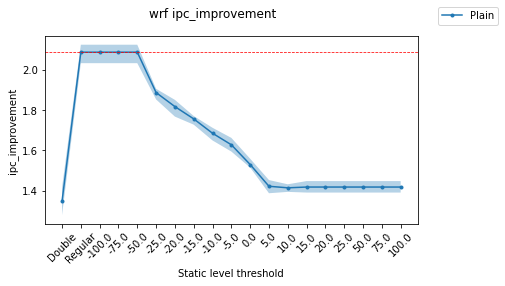

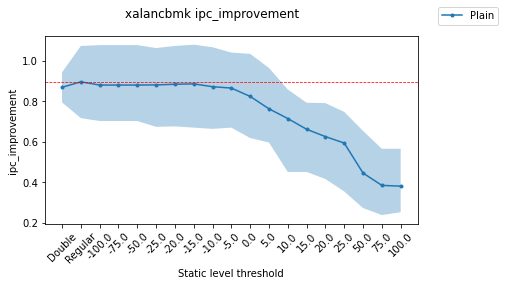

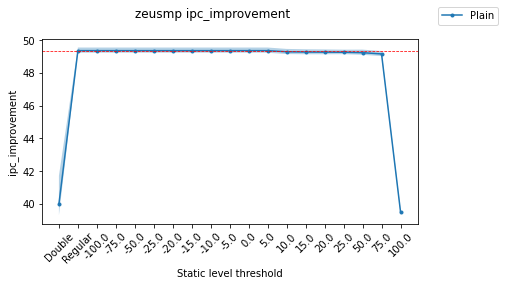

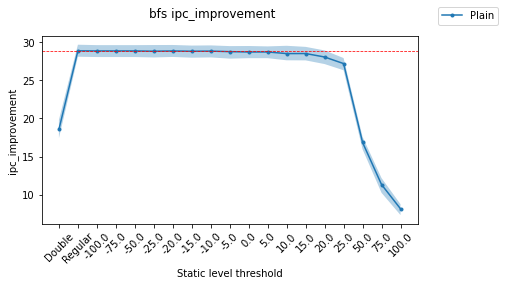

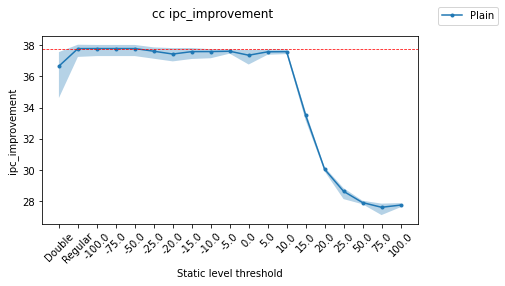

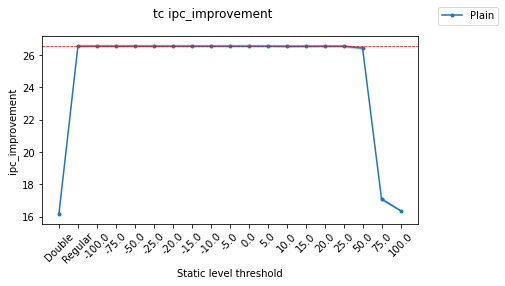

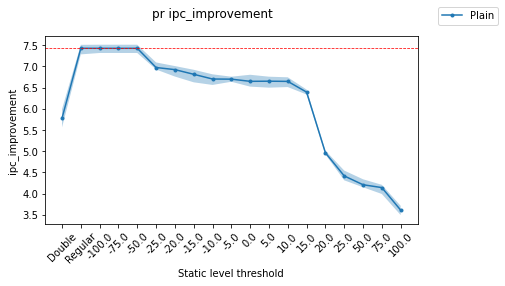

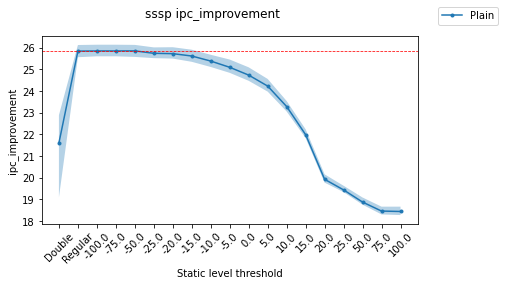

In [48]:
dpi=None
view_error='shaded'
for tr in traces.unique():
    plot_threshold_metric(
        data_df, tr, 'ipc_improvement', 
        error=view_error,
        dpi=dpi
    )
    plt.savefig(
        f'./plots/pythia_level_threshold_multi/ipc_improvement/{tr}_ipc_improvement.pdf', 
        bbox_inches='tight'
    )

## LLC MPKI reduction

/tmp/ipykernel_28820/1027629572.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(dpi=dpi)


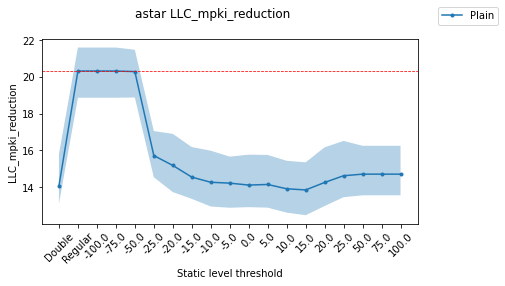

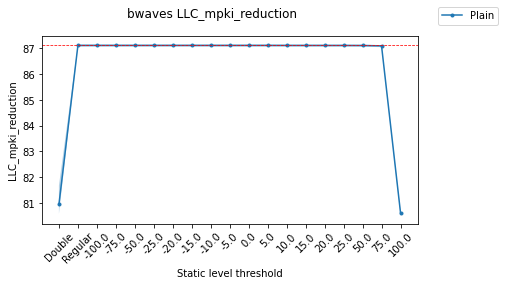

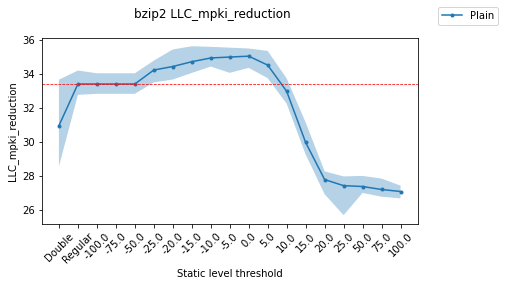

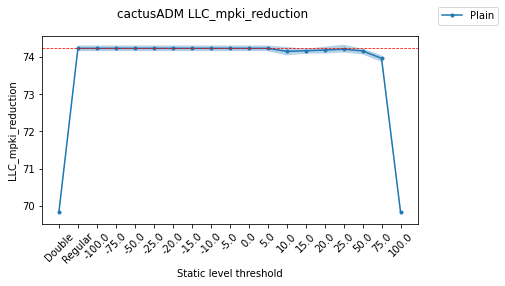

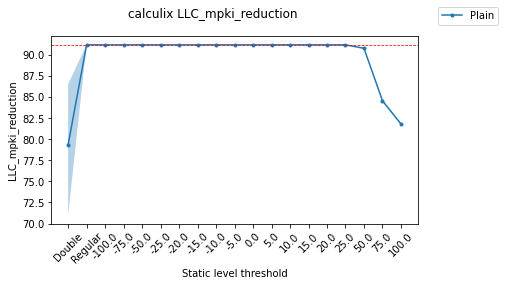

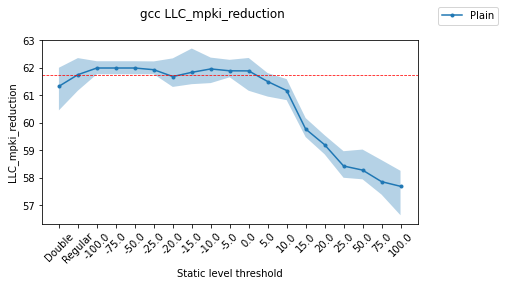

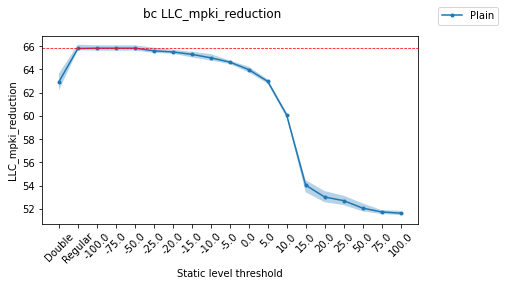

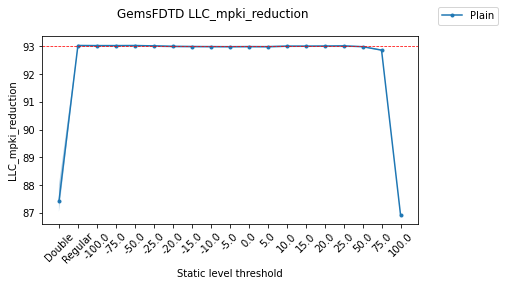

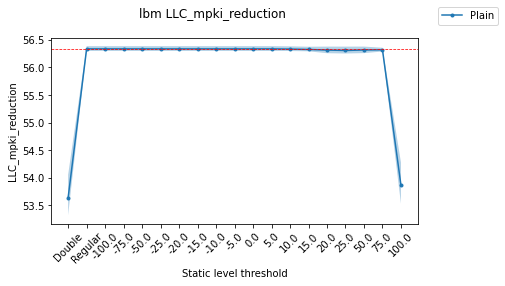

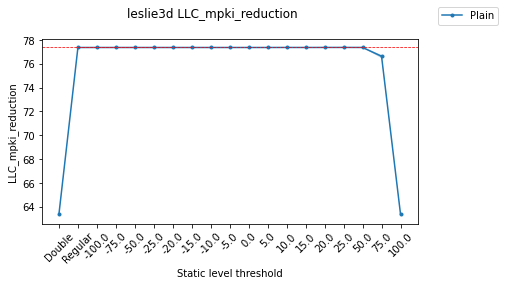

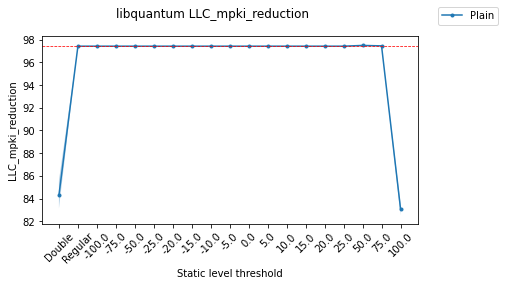

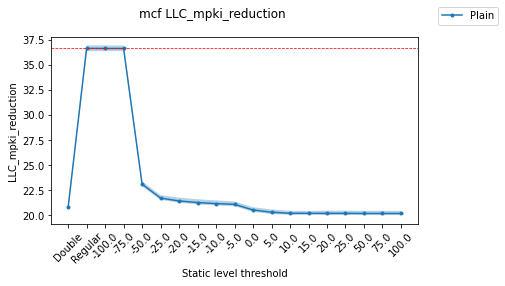

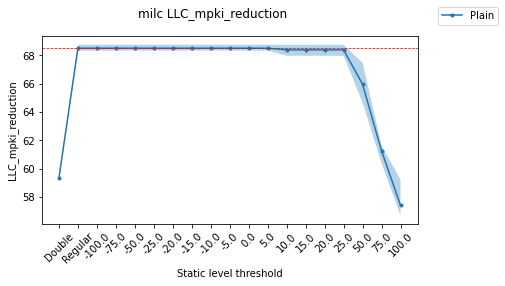

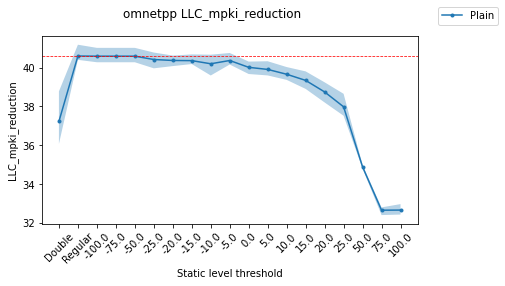

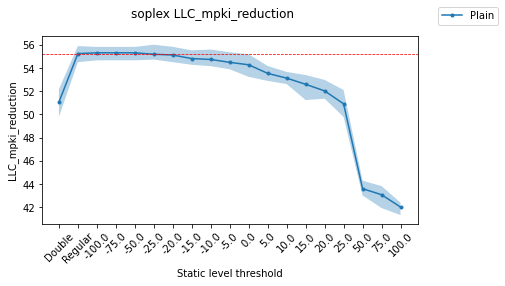

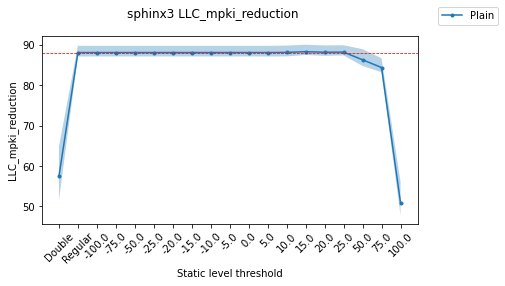

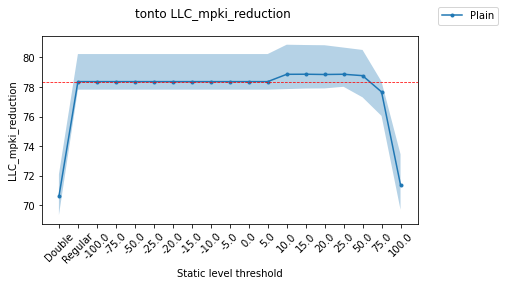

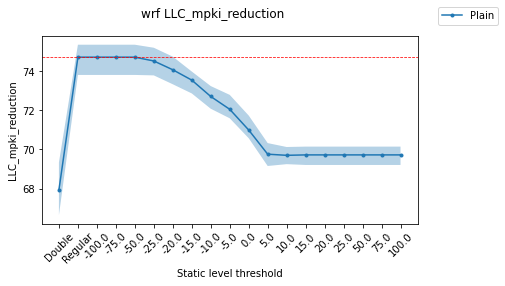

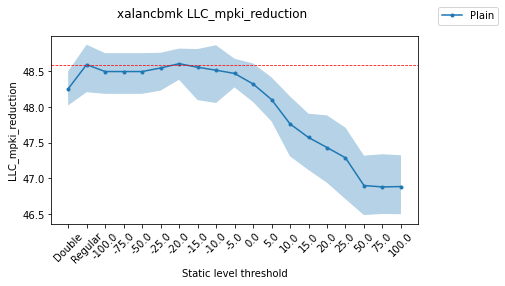

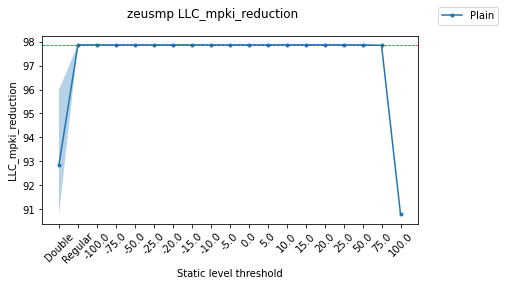

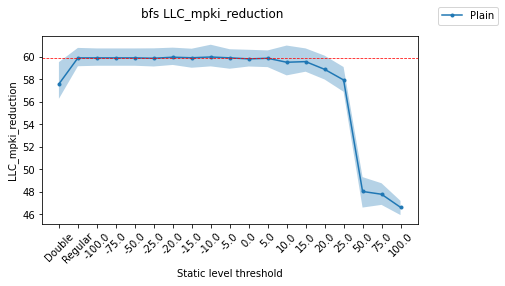

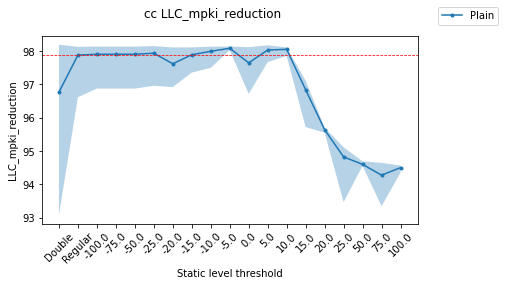

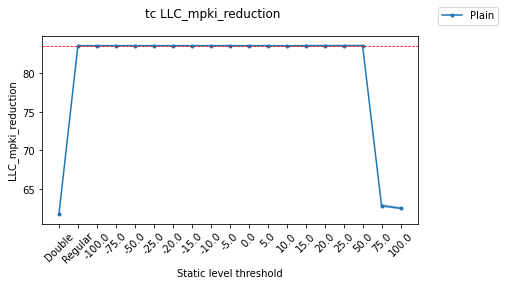

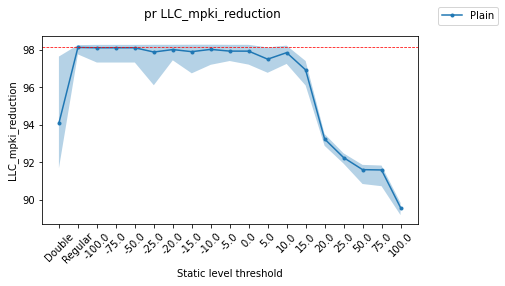

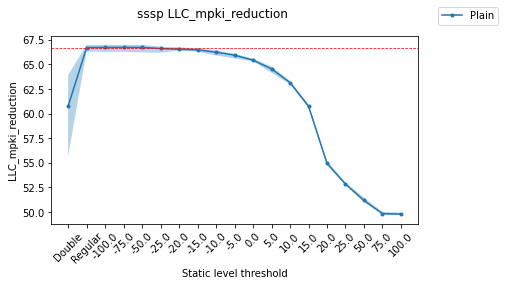

In [49]:
for tr in traces.unique():
    plot_threshold_metric(
        data_df, tr, 'LLC_mpki_reduction', 
        error=view_error,
        dpi=dpi
    )
    plt.savefig(
        f'./plots/pythia_level_threshold_multi/LLC_mpki_reduction/{tr}_LLC_mpki_reduction.pdf', 
        bbox_inches='tight'
    )

## L2C MPKI reduction

In [ ]:
for tr in traces.unique():
    plot_threshold_metric(
        data_df, tr, 'L2C_mpki_reduction', 
        error=view_error,
        dpi=dpi
    )
    plt.savefig(
        f'./plots/pythia_level_threshold_multi/L2C_mpki_reduction/{tr}_L2C_mpki_reduction.pdf', 
        bbox_inches='tight'
    )

---
# Low vs. high confidence prefetches

In [55]:
def plot_conf_prefetches(dfs, trace, dpi=192, error=None):
    fig, ax = plt.subplots(dpi=dpi)
        
    for setup, df in dfs.items():
        df = df[df.trace == trace]#[['pythia_level_threshold', metric]])
        df = df.sort_values(['pythia_level_threshold'])
        
        # Gather points for lines
        prefs, pyth_lts, X, ylow_min, ylow_mean, ylow_max, yhigh_min, yhigh_mean, yhigh_max = [], [], [], [], [], [], [], [], []
        
        for i, (pf, pyth_lt) in enumerate(product(df.all_pref.unique(), df.pythia_level_threshold.unique())):
            if pf != ('no', 'pythia', 'no') and pyth_lt != float('-inf'):
                continue
            df_ = df[(df.all_pref == pf) & (df.pythia_level_threshold == pyth_lt)][['pythia_high_conf_prefetches', 'pythia_low_conf_prefetches']]
            
            prefs.append(pf)
            pyth_lts.append(pyth_lt)
            ylow_mean.append(df_.pythia_low_conf_prefetches.mean())
            ylow_min.append(df_.pythia_low_conf_prefetches.min())
            ylow_max.append(df_.pythia_low_conf_prefetches.max())
            yhigh_mean.append(df_.pythia_high_conf_prefetches.mean())
            yhigh_min.append(df_.pythia_high_conf_prefetches.min())
            yhigh_max.append(df_.pythia_high_conf_prefetches.max())

        ylow_mean = np.array(ylow_mean)
        ylow_min = np.array(ylow_min)
        ylow_max = np.array(ylow_max)
        yhigh_mean = np.array(yhigh_mean)
        yhigh_min = np.array(yhigh_min)
        yhigh_max = np.array(yhigh_max)
        
        if error == 'bar':
            ax.errorbar(
                np.arange(0, len(ylow_mean)), ylow_mean, yerr=[ylow_mean - ylow_min, ylow_max - ylow_mean],  
                label=f'{setup} (Low)', marker='.'
            )
            ax.errorbar(
                np.arange(0, len(yhigh_mean)), yhigh_mean, yerr=[yhigh_mean - yhigh_min, yhigh_max - yhigh_mean],  
                label=f'{setup} (High)', marker='.'
            )
            ax.errorbar(
                np.arange(0, len(yhigh_mean)), ylow_mean+yhigh_mean, 
                yerr=[(ylow_mean+yhigh_mean) - (ylow_min+yhigh_min), (ylow_max+yhigh_max) - (ylow_mean+yhigh_mean)],  
                label=f'{setup} (Total)', color='black', lw=1, ls='--',
            )
        else:
            ax.plot(
                np.arange(0, len(ylow_mean)), ylow_mean,
                label=f'{setup} (Low)', marker='.'
            )
            ax.plot(
                np.arange(0, len(yhigh_mean)), yhigh_mean, 
                label=f'{setup} (High)', marker='.'
            )
            ax.plot(
                np.arange(0, len(yhigh_mean)), ylow_mean+yhigh_mean, 
                label=f'{setup} (Total)', color='black', lw=1, ls='--',
            ) 
            if error == 'shaded':
                ax.fill_between(
                    np.arange(0, len(ylow_mean)), ylow_min, ylow_max,
                    alpha=0.33
                )
                ax.fill_between(
                    np.arange(0, len(yhigh_mean)), yhigh_min, yhigh_max,
                    alpha=0.33
                )
                ax.fill_between(
                    np.arange(0, len(yhigh_mean)), ylow_min+yhigh_min, ylow_max+yhigh_max,
                    color='black', alpha=0.33
                )
    
    ax.set_xticks(np.arange(len(ylow_mean)))
    ax.set_xticklabels([
        'Double' if prefs[i] == ('no', 'double_pythia', 'no') else
        'Regular' if pyth_lts[i] == float('-inf') else 
        str(pyth_lts[i]) 
        for i in range(len(prefs))
    ], rotation=45)
                          
    ax.set_xlabel('Static level threshold')
    ax.set_ylabel('Low-confidence prefetches')
    #ax.set_ylim(ymin=0)
    
    fig.legend(bbox_to_anchor=(1.01, 1), loc='upper left', ncol=1)
    fig.suptitle(f'{trace} Prefetch confidence')
    fig.tight_layout()

/tmp/ipykernel_28820/305439384.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(dpi=dpi)


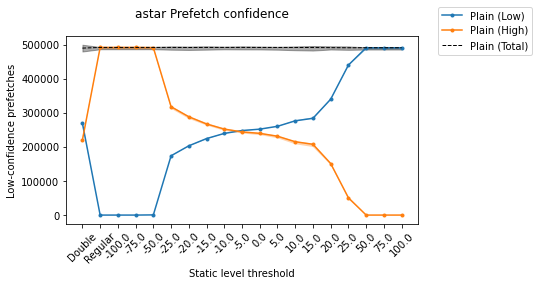

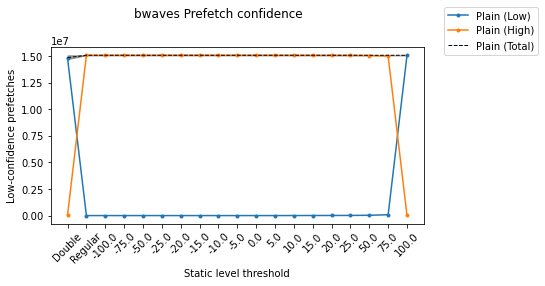

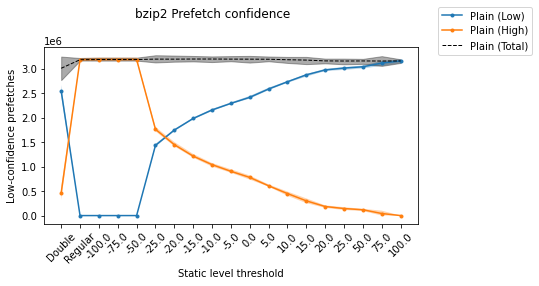

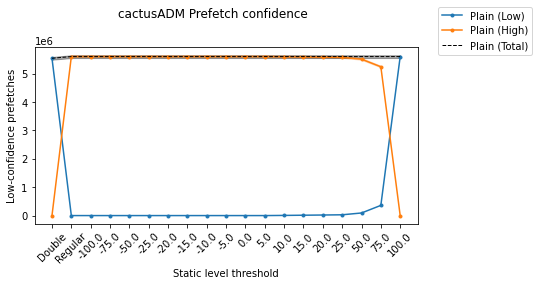

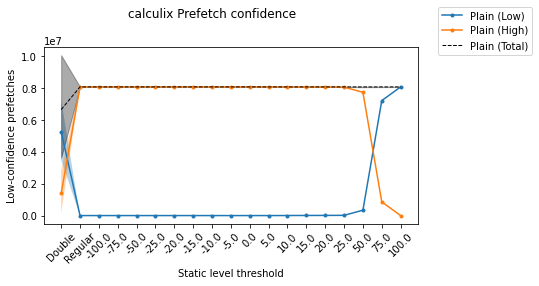

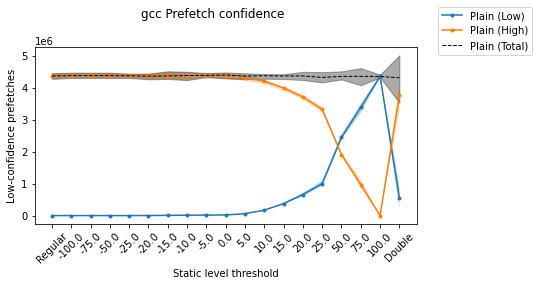

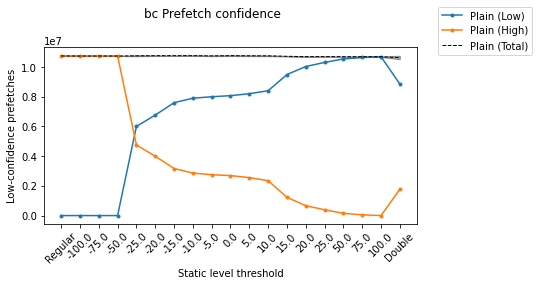

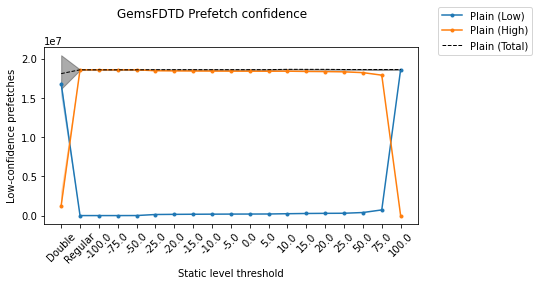

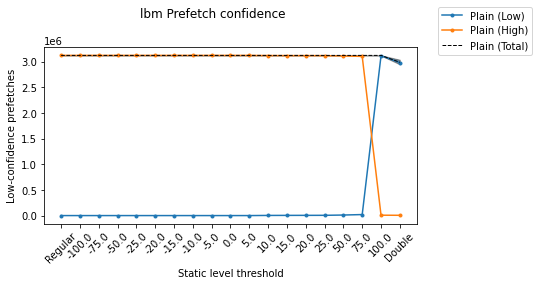

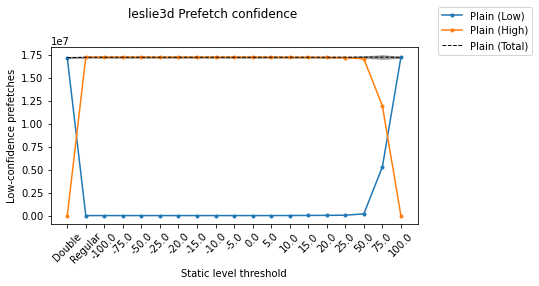

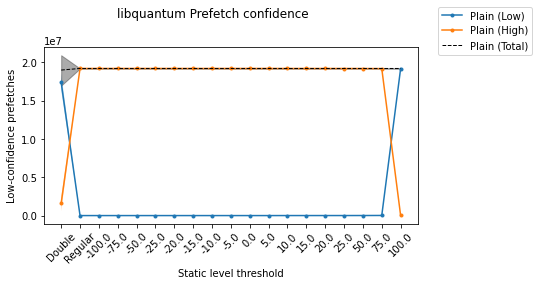

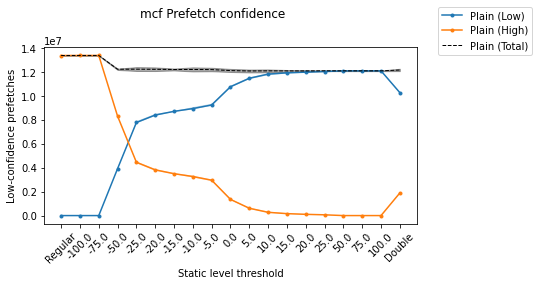

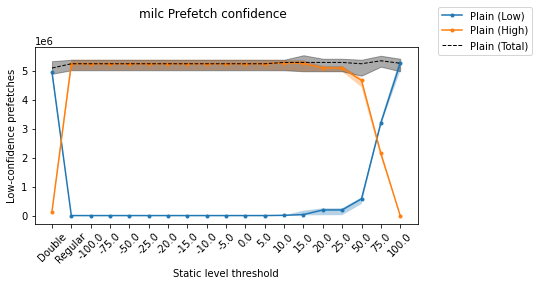

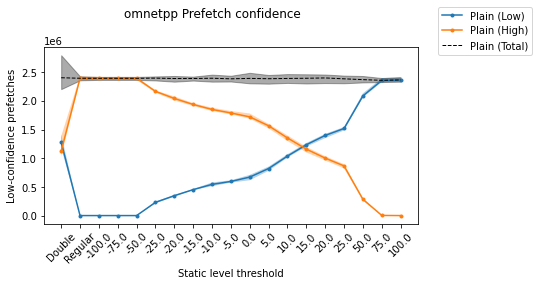

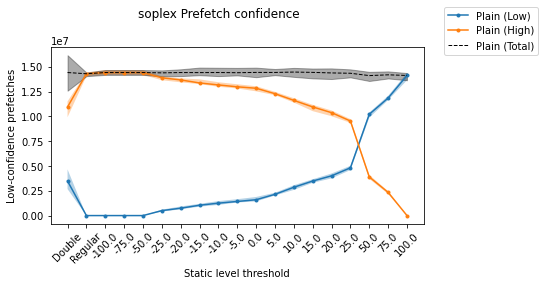

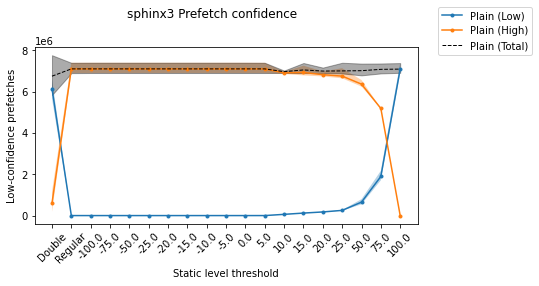

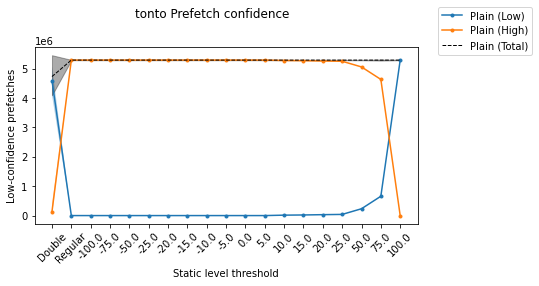

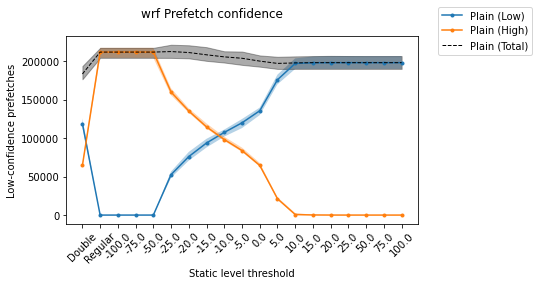

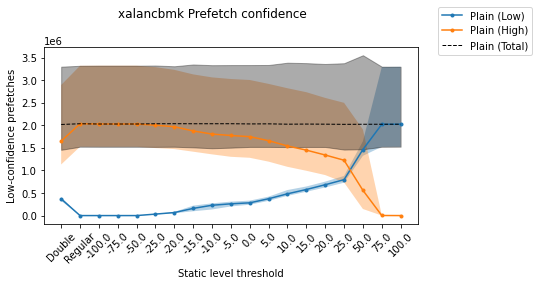

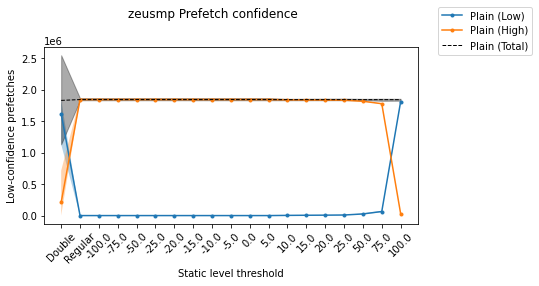

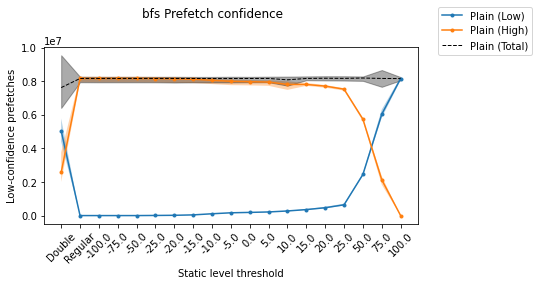

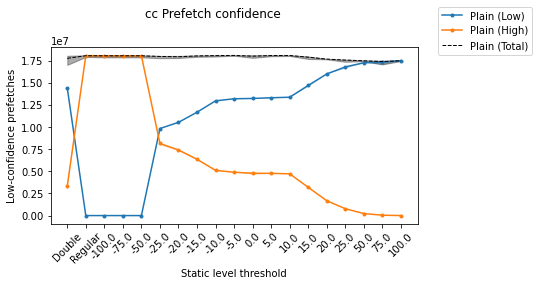

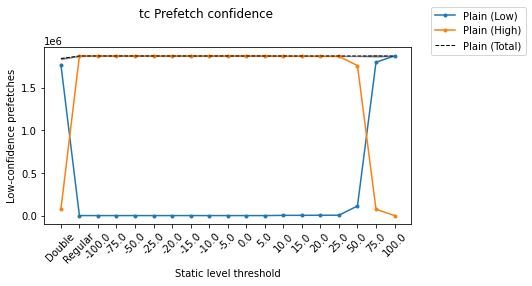

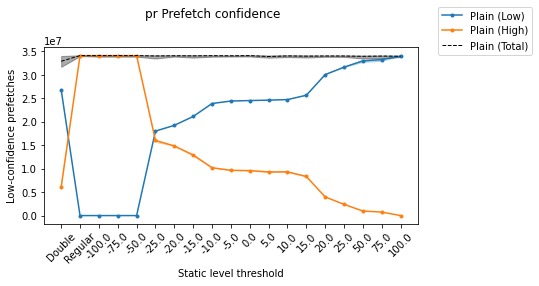

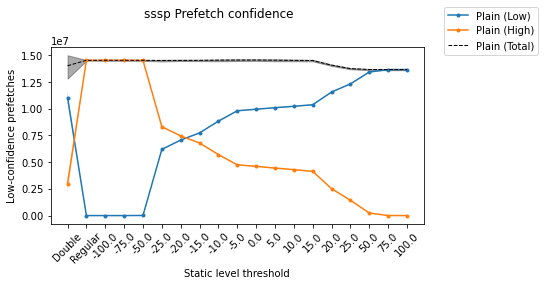

In [56]:
dpi=None
view_error='shaded'

for tr in traces.unique():
    plot_conf_prefetches(
        data_df, tr, 
        error=view_error,
        dpi=dpi
    )
    plt.savefig(
        f'./plots/pythia_level_threshold_multi/pythia_confidence/{tr}_pythia_confidence.pdf', 
        bbox_inches='tight'
    )